In [4]:
import os
import pandas as pd
df = pd.read_parquet("../train_final_v1.parquet", engine="pyarrow")
print(df.shape)
print(df.columns[:20].tolist())

(128877, 407)
['asin', 'category', 'title', 'missing_price', 'item_rank', 'match', 'incident_indices', 'component_no', 'avg_rating', 'min_rating', 'num_of_rating', 'percent_positive', 'percent_negative', 'avg_verified_reviewers', 'min_date', 'max_date', 'product_lifespan', 'num_bots_per_asin', 'unique_reviewer_count', 'avg_reviews_per_day']


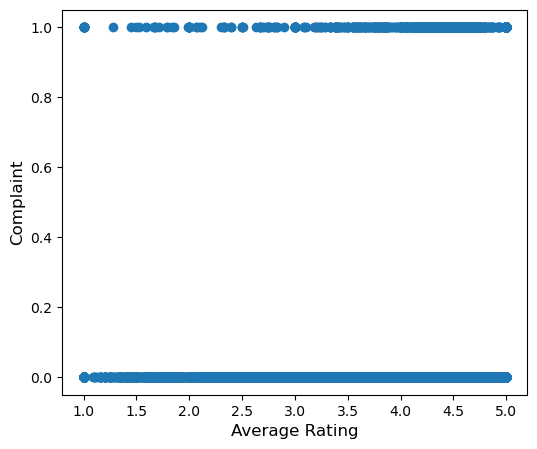

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

plt.scatter(df['avg_rating'], df['match'])

plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Complaint", fontsize=12)
plt.show()

In [9]:
import torch
import torch.nn as nn

# Increase weight on positive class (label = 1)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]))  # Try 5.0, 10.0, etc.


In [10]:
def compute_baseline_loss_all_zeros(df, label_col="match", pos_weight=1.0, device="cpu"):
    """
    Compute baseline BCEWithLogitsLoss for a model that always predicts 0.

    Parameters:
    - df: pandas DataFrame containing the label column
    - label_col: name of the label column (default: "match")
    - pos_weight: float (how much more to penalize false negatives)
    - device: "cpu" or "cuda"

    Returns:
    - loss_value: float
    """
    y_true = torch.tensor(df[label_col].values, dtype=torch.float32).to(device)

    # Simulate prediction of all 0s → logits = -100
    y_pred_logits = torch.full_like(y_true, -100.0, device=device)

    pos_weight_tensor = torch.tensor([pos_weight], device=device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    loss = loss_fn(y_pred_logits, y_true)
    return loss.item()


In [11]:
baseline_loss = compute_baseline_loss_all_zeros(df, label_col="match", pos_weight=5.0)
print("Baseline loss (predict all 0s):", baseline_loss)


Baseline loss (predict all 0s): 3.4024689197540283


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# X = just the 'average_rating' column, reshaped as 2D
X = df[['avg_rating']]  # or df['average_rating'].values.reshape(-1, 1)
y = df['match']
